In [82]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import recall_score


### Splitting Train/Test and OHE categorical columns

In [83]:
df = pd.read_parquet("../../01_data/processed/dataset_clean.parquet")

X = df.drop(columns=["y"])
y = df["y"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train.shape, X_test.shape

((24382, 19), (6096, 19))

In [84]:
cat_cols = X_train.select_dtypes(include="object").columns
num_cols = X_train.select_dtypes(exclude="object").columns

cat_cols, num_cols

(Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
        'month', 'day_of_week', 'poutcome'],
       dtype='object'),
 Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
        'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
       dtype='object'))

In [85]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

### Logistic regression (baseline)

In [86]:
lr = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",  #class imbalance
    random_state=42
)

In [87]:
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", lr),
    ]
)

model.fit(X_train, y_train)

c:\Users\JoepSticker\miniconda3\envs\py311\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

In [88]:
lr_pred = model.predict(X_test)
lr_proba = model.predict_proba(X_test)[:, 1]

confusion_matrix(y_test, lr_pred)

array([[4374,  950],
       [ 274,  498]])

In [89]:
print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

           0       0.94      0.82      0.88      5324
           1       0.34      0.65      0.45       772

    accuracy                           0.80      6096
   macro avg       0.64      0.73      0.66      6096
weighted avg       0.87      0.80      0.82      6096



In [90]:
lr_AUC = roc_auc_score(y_test, lr_proba) #Logistic regression AUC as baseline
lr_AUC

0.7882092723146336

In [91]:
precision, recall, thresholds = precision_recall_curve(y_test, lr_proba)

avg_precision = average_precision_score(y_test, lr_proba)
avg_precision

0.42885703765389444

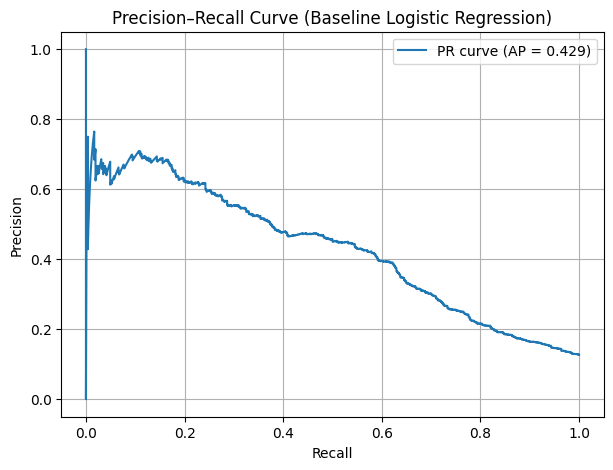

In [92]:
plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f"PR curve (AP = {avg_precision:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Baseline Logistic Regression)")
plt.legend()
plt.grid(True)
plt.show()

In [93]:
# Precision 0.3, 0.35, 0.4, 0.45, 0.50 with max recall (chosen to make recall heavy artifact metric due to cost of missed opportunity being higher than cost of non-prospect being mislabeled as opportunity)
# Precision of calling everyone = TP/total test set = 0.13

constraints = [0.30, 0.35, 0.40, 0.45, 0.50]

for p in constraints:
    r = recall[:-1][precision[:-1] >= p].max()
    print(f"precision ≥ {p:.2f} → recall = {r:.3f}")


precision ≥ 0.30 → recall = 0.701
precision ≥ 0.35 → recall = 0.637
precision ≥ 0.40 → recall = 0.592
precision ≥ 0.45 → recall = 0.531
precision ≥ 0.50 → recall = 0.374


In [94]:
pr_df = pd.DataFrame({
    "threshold": thresholds,
    "precision": precision[:-1],
    "recall": recall[:-1],
})


candidate_thresholds = pr_df[pr_df["precision"] >= 0.35]
candidate_thresholds.sort_values("recall", ascending=False).head()

,threshold,precision,recall
4621,0.511710,0.350178,0.637306
4622,0.512708,0.350427,0.637306
4623,0.512903,0.350677,0.637306
4624,0.513023,0.350927,0.637306
4625,0.513179,0.351178,0.637306


In [95]:
# Give threshold for chosen parameter for artifact = 0.35

def threshold_at_precision(y_true, y_proba, min_precision=0.35):
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)

    # precision and recall are 1 object longer than thresholds
    precision = precision[:-1]
    recall = recall[:-1]

    mask = precision >= min_precision
    best_idx = np.argmax(recall[mask])

    return thresholds[mask][best_idx]

In [96]:
# Accompanying threshold = 0.512, meaning a call gets made when model predicts y=1 with 51% certainty. Threshold only helps create confusion matrix and does not explain model performance in itself.

lr_threshold = threshold_at_precision(y_test, lr_proba, 0.35)
lr_pred = (lr_proba >= lr_threshold).astype(int)
lr_threshold

np.float64(0.5117104735311018)

In [97]:
# Model performance with chosen parameter

y_pred_final_lr = (lr_proba >= lr_threshold).astype(int)

confusion_matrix(y_test, y_pred_final_lr)

array([[4411,  913],
       [ 280,  492]])

In [98]:
print(classification_report(y_test, y_pred_final_lr, digits=3))

              precision    recall  f1-score   support

           0      0.940     0.829     0.881      5324
           1      0.350     0.637     0.452       772

    accuracy                          0.804      6096
   macro avg      0.645     0.733     0.666      6096
weighted avg      0.866     0.804     0.827      6096



### Random forest classifier

In [99]:
rfc = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=50,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

In [100]:
rfc_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", rfc)
])

rfc_pipe.fit(X_train, y_train)
rfc_proba = rfc_pipe.predict_proba(X_test)[:, 1]

rfc_proba

array([0.45360551, 0.20096559, 0.80842838, ..., 0.29485267, 0.23980326,
       0.2301527 ], shape=(6096,))

In [101]:
rfc_AUC = roc_auc_score(y_test, rfc_proba)
rfc_AUC

0.7981773317035381

In [102]:
# calculate rfc average precision and compare with lr precision of 0.430

rfc_precision, rfc_recall, rfc_thresholds = precision_recall_curve(y_test, rfc_proba)
rfc_ap = average_precision_score(y_test, rfc_proba)

rfc_ap

0.4603036580554547

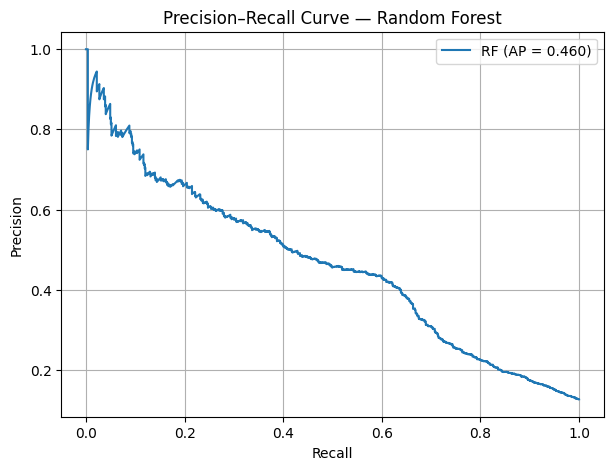

In [103]:
plt.figure(figsize=(7, 5))
plt.plot(rfc_recall, rfc_precision, label=f"RF (AP = {rfc_ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — Random Forest")
plt.legend()
plt.grid(True)
plt.show()

In [104]:
# Precision 0.35 with max recall (same as lr)

precision, recall, _ = precision_recall_curve(y_test, rfc_proba)
print(f"Random Forest: {recall[precision >= 0.35].max():.3f}")

Random Forest: 0.667


In [105]:
# Chosen parameter for artifact = 0.35
# Accompanying threshold = 0.467, meaning a call gets made when model predicts y=1 with 46.7% certainty

rfc_threshold = threshold_at_precision(y_test, rfc_proba, 0.35)

print("threshold", rfc_threshold)


threshold 0.4667112977514638


In [106]:
# Model performance with chosen parameter

y_pred_rfc = (rfc_proba >= rfc_threshold).astype(int)

confusion_matrix(y_test, y_pred_rfc)

array([[4368,  956],
       [ 257,  515]])

In [107]:
print(classification_report(y_test, y_pred_rfc, digits=3))

              precision    recall  f1-score   support

           0      0.944     0.820     0.878      5324
           1      0.350     0.667     0.459       772

    accuracy                          0.801      6096
   macro avg      0.647     0.744     0.669      6096
weighted avg      0.869     0.801     0.825      6096



### XGBoost

In [108]:
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

xgb_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", xgb)
])

xgb_pipe.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

In [109]:
xgb_proba = xgb_pipe.predict_proba(X_test)[:, 1]

xgb_precision, xgb_recall, xgb_thresholds = precision_recall_curve(y_test, xgb_proba)
xgb_ap = average_precision_score(y_test, xgb_proba)

In [110]:
xgb_AUC = roc_auc_score(y_test, xgb_proba)
xgb_AUC

0.8017346418408381

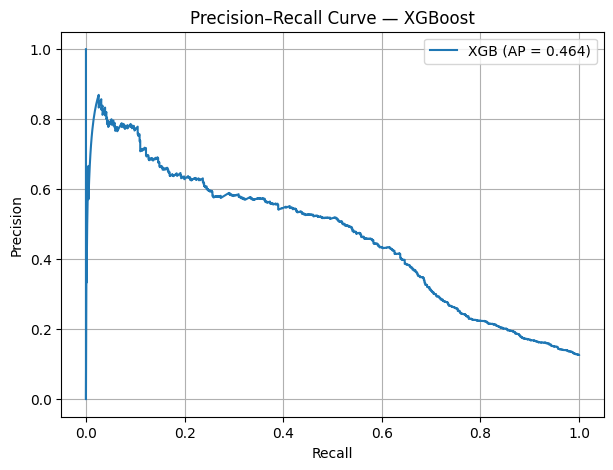

In [111]:
plt.figure(figsize=(7, 5))
plt.plot(xgb_recall, xgb_precision, label=f"XGB (AP = {xgb_ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — XGBoost")
plt.legend()
plt.grid(True)
plt.show()

In [112]:
precision, recall, _ = precision_recall_curve(y_test, xgb_proba)
print(f"XGBoost: {recall[precision >= 0.35].max():.3f}")

XGBoost: 0.677


In [113]:
# Find threshold for precision >= 0.35 with max recall
xgb_threshold = threshold_at_precision(y_test, xgb_proba, 0.35)

print("threshold", xgb_threshold)

threshold 0.11625654


In [114]:
# Predicitons at chosen threshold
y_pred_xgb = (xgb_proba >= xgb_threshold).astype(int)

# Evaluation
confusion_matrix(y_test, y_pred_xgb)

array([[4353,  971],
       [ 249,  523]])

In [115]:
print(classification_report(y_test, y_pred_xgb, digits=3))

              precision    recall  f1-score   support

           0      0.946     0.818     0.877      5324
           1      0.350     0.677     0.462       772

    accuracy                          0.800      6096
   macro avg      0.648     0.748     0.669      6096
weighted avg      0.870     0.800     0.824      6096



### Soft voting stacked models

In [116]:
stacked_clf = StackingClassifier(
    estimators=[
        ("lr", lr ),
        ("rf", rfc),
        ("xgb", xgb)
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    stack_method="predict_proba",
    cv=5,
    n_jobs=-1
)

In [117]:
stacked_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", stacked_clf)
])

stacked_pipe.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

In [118]:
stacked_proba = stacked_pipe.predict_proba(X_test)[:, 1]

stacked_AUC = roc_auc_score(y_test, stacked_proba)
stacked_AUC

0.8014896373056994

In [119]:
# Precision-recall curve
stacked_precision, stacked_recall, stacked_thresholds = precision_recall_curve(
    y_test, stacked_proba)

stacked_ap = average_precision_score(y_test, stacked_proba)

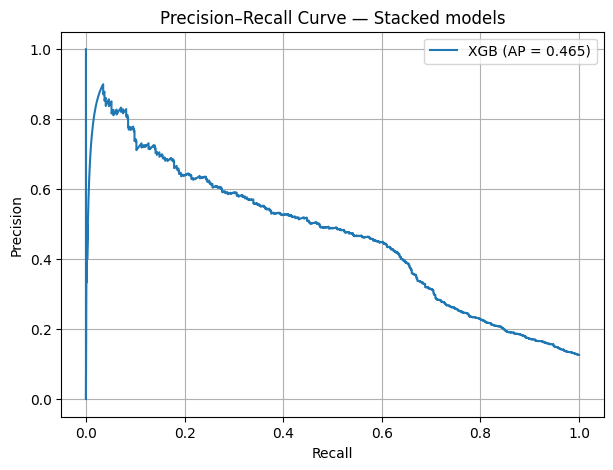

In [120]:
plt.figure(figsize=(7, 5))
plt.plot(stacked_recall, stacked_precision, label=f"XGB (AP = {stacked_ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — Stacked models")
plt.legend()
plt.grid(True)
plt.show()

In [121]:
precision, recall, _ = precision_recall_curve(y_test, stacked_proba)
print(f"Stacked model: {recall[precision >= 0.35].max():.3f}")

Stacked model: 0.670


In [122]:
# threshold at precision >=0.35
stacked_threshold = threshold_at_precision(y_test, stacked_proba, 0.35)
print("threshold", stacked_threshold)

threshold 0.10382668419276028


In [123]:
# Predictions at chosen threshold
y_pred_stacked = (stacked_proba >= stacked_threshold).astype(int)

# Evaluation
confusion_matrix(y_test, y_pred_stacked)

array([[4364,  960],
       [ 255,  517]])

In [124]:
print(classification_report(y_test, y_pred_stacked, digits=3))

              precision    recall  f1-score   support

           0      0.945     0.820     0.878      5324
           1      0.350     0.670     0.460       772

    accuracy                          0.801      6096
   macro avg      0.647     0.745     0.669      6096
weighted avg      0.869     0.801     0.825      6096



In [125]:
# AUC for overall model performance

print(f"Logistic Regression AUC: {roc_auc_score(y_test, lr_proba):.3f}")
print(f"Random Forest AUC:       {roc_auc_score(y_test, rfc_proba):.3f}")
print(f"XGBoost AUC:             {roc_auc_score(y_test, xgb_proba):.3f}")
print(f"Stacked model AUC:       {roc_auc_score(y_test, stacked_proba):.3f}")

Logistic Regression AUC: 0.788
Random Forest AUC:       0.798
XGBoost AUC:             0.802
Stacked model AUC:       0.801


In [128]:
# Recall for all models at precision 0.35

from sklearn.metrics import recall_score

print(f"Logistic Regression: {recall_score(y_test, (lr_proba >= lr_threshold).astype(int)):.3f}")
print(f"Random Forest:       {recall_score(y_test, (rfc_proba >= rfc_threshold).astype(int)):.3f}")
print(f"XGBoost:             {recall_score(y_test, (xgb_proba >= xgb_threshold).astype(int)):.3f}")
print(f"Stacked model:       {recall_score(y_test, (stacked_proba >= stacked_threshold).astype(int)):.3f}")

Logistic Regression: 0.637
Random Forest:       0.667
XGBoost:             0.677
Stacked model:       0.670
